# Jorual DAO: A New Framework for DeSci in Web 3.0

In [1]:
from math import floor
import pandas as pd
from random import randint
import matplotlib.pyplot as plt

## type

In [2]:
class IUser():
  address: int
  token: int
  def __init__(self, address:str, token:int) -> None:
    self.address = address
    self.token = token

class IReview(IUser):
  rating: int
  def __init__(self, address:str, rating:int) -> None:
    self.rating = rating
    super().__init__(address, 0)

class IAuthor(IUser):
  sequence: int
  weight: int
  def __init__(self, address:str, sequence:int) -> None:
    self.sequence = sequence
    super().__init__(address, 0)

class ICitedBy(IUser):
  articleID: int
  def __init__(self, address:str, articleID:int) -> None:
    self.articleID = articleID
    super().__init__(address, 0)



## dao class

In [3]:
class ArticleDAO:
  _distribution:list[IUser]
  _articleID = None
  _authors:list[IAuthor]
  _reviewers:list[IReview]
  _downloads:list[IUser]
  _cites:list[ICitedBy]
  _holder =pd.DataFrame()
  _log = pd.DataFrame()
  _finance = pd.DataFrame()
  DOWNLOAD_FEE = 1
  AUTHOR_TOKEN = 1000
  REVIEW_TOKEN = 1000
  DOWNLOAD_TOKEN = 18
  DOWNLOAD_AUTHOR_TOKEN = 24
  CITE_TOKEN = 36
  CITE_ATHOR_TOKEN = 6
  def __init__(self, articleID:int, authors:list[str]):
    self._articleID = articleID
    self._authors = list()
    for i, author in enumerate(authors):
      self._authors.append(IAuthor(author, i))
    self._reviewers = list()
    self._downloads = list()
    self._cites = list()
    self._distribution = list()

  def review(self, reviews:list[IReview]):
    total = sum(review.rating for review in reviews)
    for review in reviews:
      rating = 0
      if review.rating >= 5:
        rating = 5
      elif review.rating <= 1:
        rating = 1
      else:
        rating = review.rating
      review.token = floor(rating  / total * self.REVIEW_TOKEN)
    self._reviewers = reviews

    weight_len = 0
    for i, author in enumerate(self._authors):
      if i == 0:
        author.weight = 4
      elif i == 1:
        author.weight = 6
      elif i == 2:
        author.weight = 2
      else:
        author.weight = 1
      weight_len += author.weight
    for i, author in enumerate(self._authors):
      author.token = floor((author.weight / weight_len) * self.AUTHOR_TOKEN)
    self.record()

  def download(self, address:str):
    user = next((obj for obj in self._downloads if obj.address == address), None)
    if user:
      return
      # user.token = user.token + 1
    else:
      self._downloads.append(IUser(address, self.DOWNLOAD_TOKEN))
    total = sum(author.weight if author.weight > 1 else 0 for author in self._authors)
    for author in self._authors:
      if author.weight > 1:
        author.token += floor((author.weight / total) * self.DOWNLOAD_AUTHOR_TOKEN)
    self.record()

  def cite(self, address:str):
    user = next((obj for obj in self._cites if obj.address == address), None)
    if user:
      user.token = user.token + self.CITE_TOKEN
    else:
      self._cites.append(IUser(address, self.CITE_TOKEN))
    total = sum(author.weight for author in self._authors if author.weight > 1)
    for author in self._authors:
      author.token += floor((author.weight / total) * self.CITE_ATHOR_TOKEN)
    self.record(True)

  def record(self, cite:bool=False):
    data = {}
    total = 0
    for obj in self._authors:
      data[obj.address] = [obj.token]
      total += obj.token

    for obj in self._reviewers:
      data[obj.address] = [obj.token]
      total += obj.token

    num = len(self._cites)
    if num > 0:
      data['Cite'] = self.CITE_TOKEN
      data['CiteSum'] = num * self.CITE_TOKEN
    else: 
      data['Cite'] = None
      data['CiteSum'] = None
    total += num * self.CITE_TOKEN

    num = len(self._downloads)
    if len(self._downloads) > 0:
      data['Download'] = self.DOWNLOAD_TOKEN
      data['DownloadSum'] = num * self.DOWNLOAD_TOKEN
    else:
      data['Download'] = None
      data['DownloadSum'] = None
    total += num * self.DOWNLOAD_TOKEN

    row = pd.DataFrame(data)
    self._holder = pd.concat([self._holder, row], ignore_index=True)
    frac = row.divide(total, axis=0)
    self._log = pd.concat([self._log, frac], ignore_index=True)
    if not cite:
      self._finance = pd.concat([self._finance, frac * self.DOWNLOAD_FEE], ignore_index=True)
  
  def emulate(self, download:int, cite:int):
    arr = []
    for i in range(download):
      arr.append({'address':'u' + str(i), 'type':'d'})
    for i in range(cite):
      index = randint(0, len(arr) - 1)
      arr.insert(index, {'address':'u' + str(randint(0,index)), 'type':'c'})
    for d in arr:
      if d['type'] == 'd':
        self.download(d['address'])
      else:
        self.cite(d['address'])
  
  def show(self):
    return self._log
  
  def proportion(self, names:list[str] = []):
    df = pd.DataFrame()
    for name in names:
      df[name] = self._log[name]
    ax = df.plot()
    ax.set_xlabel('Downloads & Citations')
    ax.set_ylabel('Proportion')

  def revenue(self, names:list[str] = []):
    df = pd.DataFrame()
    for name in names:
      df[name] = self._finance[name].cumsum()
    df.plot(title='Revenue')

  def revenue_user(self):
    # 显示清除下载者入场时间
    df = pd.DataFrame()
    for name in ['Download', 'Cite']:
      df[name] = self._finance[name].cumsum()
    ax = df.plot(title='Revenue')
    ax.axhline(y=1, color='r', linestyle='--')
  
  def holder(self):
    return self._holder
  
  def finance(self):
    df = self._finance.copy()
    column_sums = df.sum()
    df.loc['Total'] = column_sums
    return df
    

## run instance

C:\Users\minam\AppData\Local\Temp\ipykernel_24720\1597540399.py:112: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._log = pd.concat([self._log, frac], ignore_index=True)
C:\Users\minam\AppData\Local\Temp\ipykernel_24720\1597540399.py:114: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self._finance = pd.concat([self._finance, frac * self.DOWNLOAD_FEE], ignore_index=True)


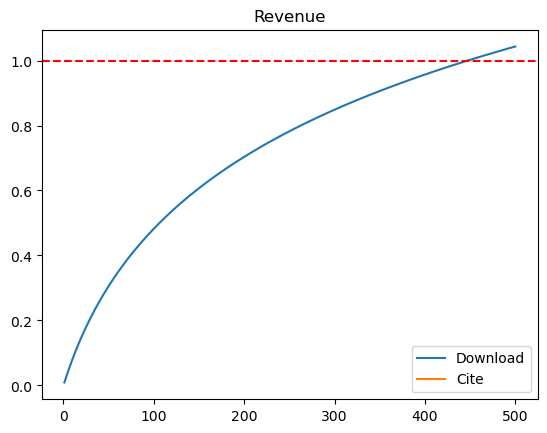

In [8]:
article = ArticleDAO(1, ['Corresponding', 'Author1','Author2','Author3'])
article.review([IReview(address='Reviewer1', rating=4), IReview(address='Reviewer2', rating=5), IReview(address='Reviewer3', rating=3)])

article.emulate(500, 0)
# article.emulate(2154, 42)

# article.show()
# article.revenue(names=['download', 'cite'])
article.revenue_user()

In [108]:
article.holder()

,Corresponding,Author1,Author2,Author3,Reviewer1,Reviewer2,Reviewer3,Cite,CiteSum,Download,DownloadSum
0,307,461,153,76,333,416,250,None,None,None,None
1,315,473,157,76,333,416,250,None,None,24,24
2,323,485,161,76,333,416,250,None,None,24,48
3,331,497,165,76,333,416,250,None,None,24,72
4,339,509,169,76,333,416,250,None,None,24,96
...,...,...,...,...,...,...,...,...,...,...,...
2192,17591,26387,8795,76,333,416,250,42,1722,24,51600
2193,17599,26399,8799,76,333,416,250,42,1722,24,51624
2194,17607,26411,8803,76,333,416,250,42,1722,24,51648
2195,17615,26423,8807,76,333,416,250,42,1722,24,51672


In [109]:
article.finance()

,Corresponding,Author1,Author2,Author3,Reviewer1,Reviewer2,Reviewer3,Cite,CiteSum,Download,DownloadSum
0,0.153808,0.230962,0.076653,0.038076,0.166834,0.208417,0.125251,NaN,NaN,NaN,NaN
1,0.154110,0.231409,0.076810,0.037182,0.162916,0.203523,0.122309,NaN,NaN,0.011742,0.011742
2,0.154398,0.231836,0.076960,0.036329,0.159178,0.198853,0.119503,NaN,NaN,0.011472,0.022945
3,0.154673,0.232243,0.077103,0.035514,0.155607,0.194393,0.116822,NaN,NaN,0.011215,0.033645
4,0.154936,0.232633,0.077239,0.034735,0.152194,0.190128,0.114260,NaN,NaN,0.010969,0.043876
...,...,...,...,...,...,...,...,...,...,...,...
2151,0.164142,0.246218,0.082066,0.000709,0.003106,0.003880,0.002332,0.000392,0.016061,0.000224,0.481486
2152,0.164143,0.246220,0.082067,0.000709,0.003104,0.003878,0.002331,0.000392,0.016054,0.000224,0.481495
2153,0.164144,0.246221,0.082068,0.000708,0.003103,0.003876,0.002330,0.000391,0.016046,0.000224,0.481503
2154,0.164146,0.246223,0.082068,0.000708,0.003102,0.003875,0.002329,0.000391,0.016039,0.000224,0.481511


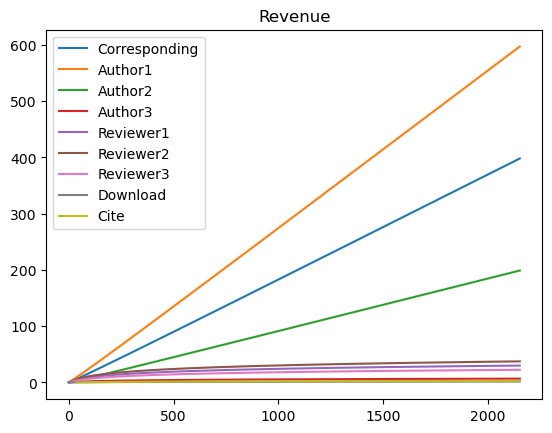

In [127]:
article.revenue(['Corresponding', 'Author1','Author2','Author3', 'Reviewer1', 'Reviewer2', 'Reviewer3', 'Download', 'Cite'])

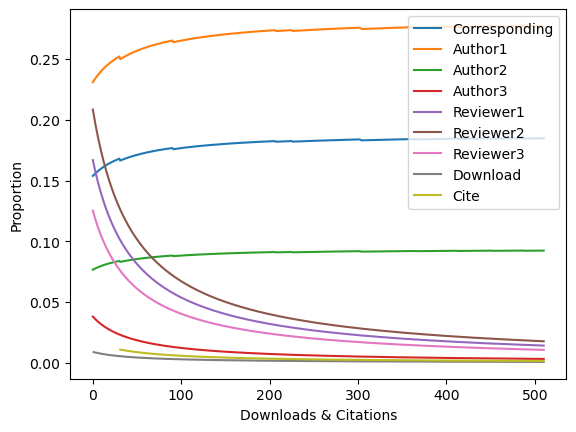

In [7]:
article.proportion(['Corresponding', 'Author1','Author2','Author3', 'Reviewer1', 'Reviewer2', 'Reviewer3', 'Download', 'Cite'])

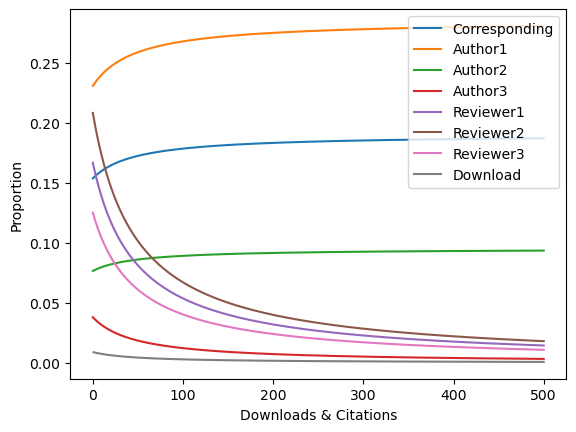

In [9]:
article.proportion(['Corresponding', 'Author1','Author2','Author3', 'Reviewer1', 'Reviewer2', 'Reviewer3', 'Download'])

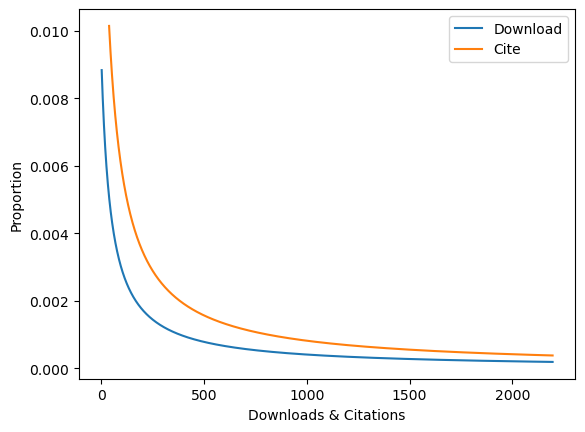

In [129]:
article.proportion(['Download', 'Cite'])

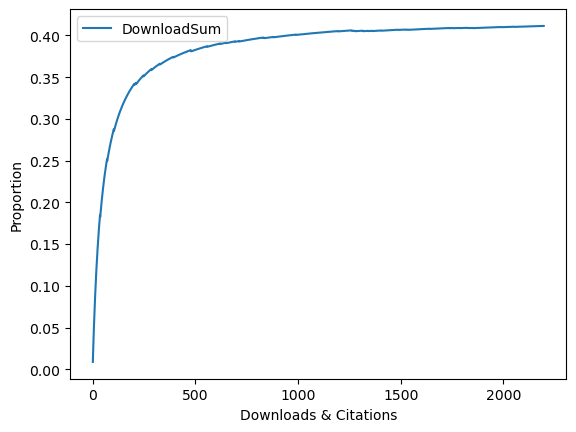

In [130]:
article.proportion(['DownloadSum'])

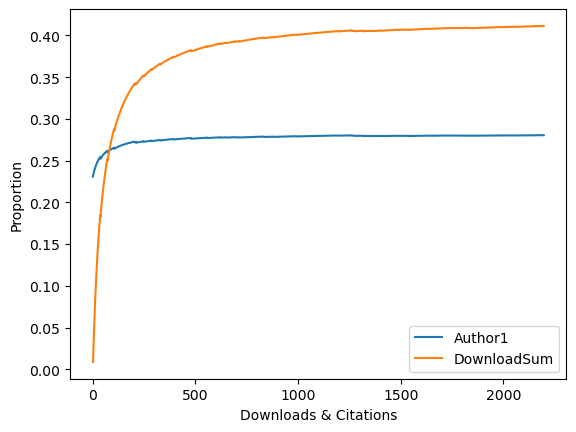

In [131]:
article.proportion(['Author1', 'DownloadSum'])

In [22]:
df = pd.DataFrame({
    'out': [20, 2154, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'in': [1000, 2000, 1500, 3000, 2500, 1800, 2800, 2200, 1900, 2100, 2400, 2700]
})
names = ['in']

df2 = pd.DataFrame()
for name in names:
  df2[name] = df[name].cumsum()
df2

,in
0,1000
1,3000
2,4500
3,7500
4,10000
5,11800
6,14600
7,16800
8,18700
9,20800
